In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import imutils
import easyocr

import os

# 1. Read in Image, Grayscale and Blur

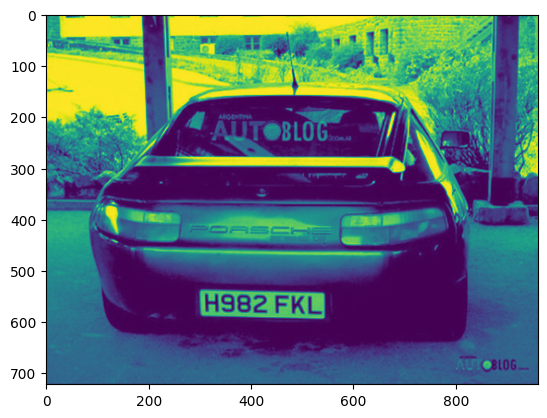

In [57]:
img = cv2.imread('example_data/image4.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

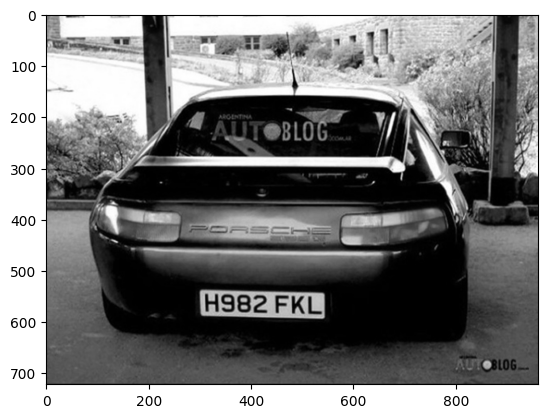

In [58]:
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

# 2. Apply filter and find edges for localization

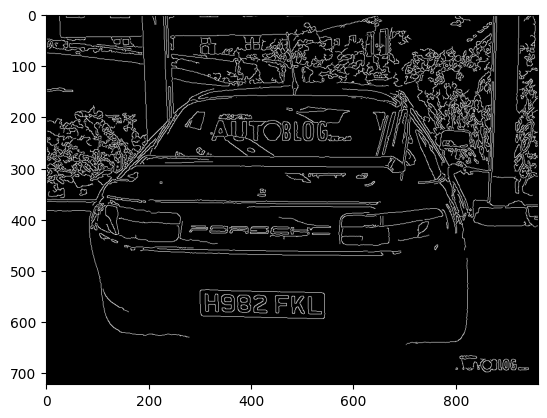

In [59]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise reduction
edged = cv2.Canny(bfilter, 30, 200) # Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

# 3. Find Contours and Apply Mask

In [60]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [61]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

location

array([[[300, 540]],

       [[306, 589]],

       [[543, 592]],

       [[538, 543]]], dtype=int32)

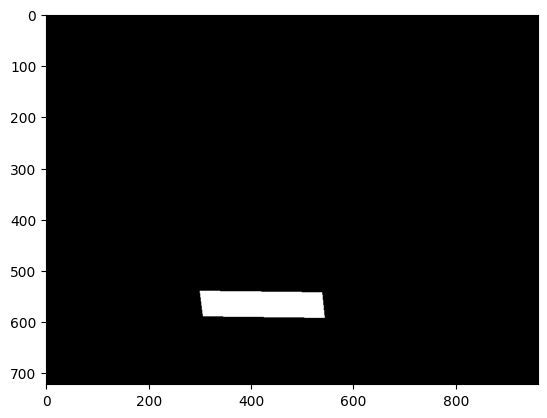

In [62]:
mask = np.zeros(gray.shape, np.uint8) # create a blank mask
new_image = cv2.drawContours(mask, [location], 0, 255, -1) # draw contours inside the mask image with location coordinates
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

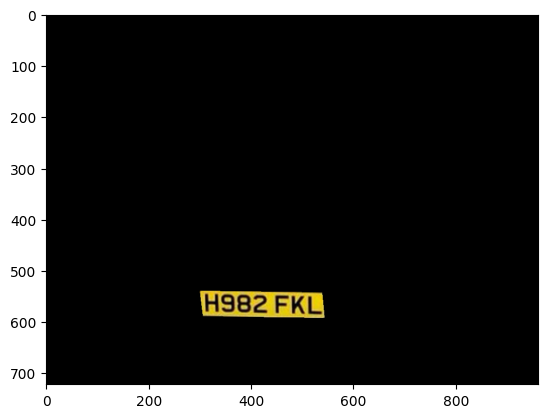

In [63]:
new_image = cv2.bitwise_and(img, img, mask=mask) # Applying masks on top of the original image
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

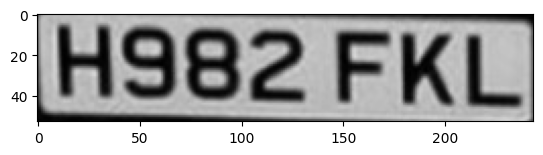

In [64]:
(x, y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2 + 1, y1:y2 + 1]

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

# 4. Use EasyOCR To Read Text

In [65]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[0, 0], [244, 0], [244, 53], [0, 53]], 'H982 FKL', 0.9757376651726158)]

# 5. Render Result

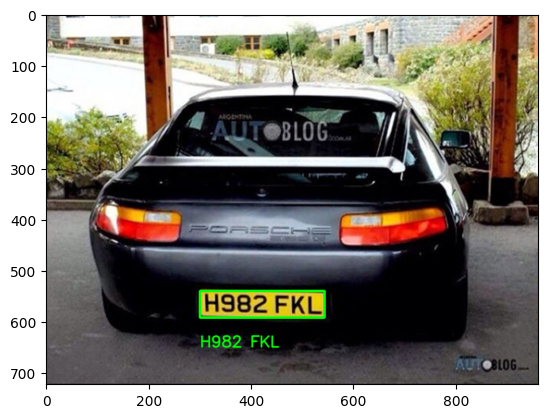

In [66]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0, 255, 0), 
                 thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0, 255, 0), 3) # draw green rectangle
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

# 6. Prepare a sample with bounding boxes

## 6.1 Read the names of the files contained in the specified directory

In [69]:
folder_path = 'example_data'
file_names = os.listdir(folder_path)

print(f"len(file_names) = {len(file_names)}")

len(file_names) = 4


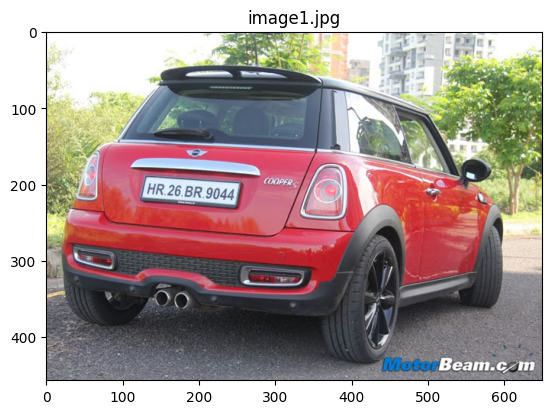

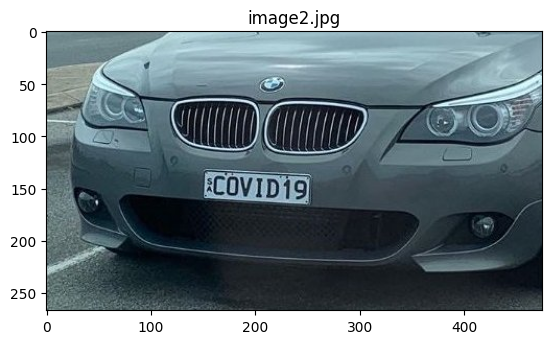

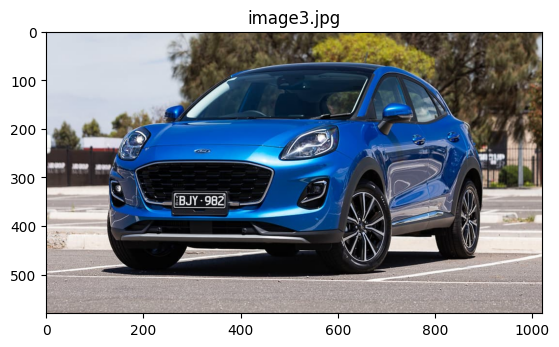

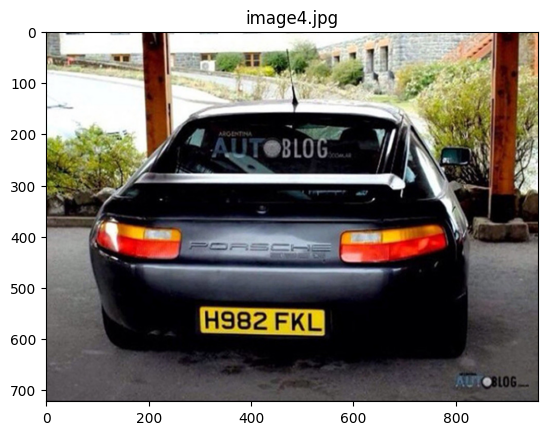

In [82]:
for file_name in file_names:
    img = cv2.imread(os.path.join(folder_path, file_name))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(file_name)
    plt.show()  # Display the current image

## 6.2 Localize license plates using the above algorithm

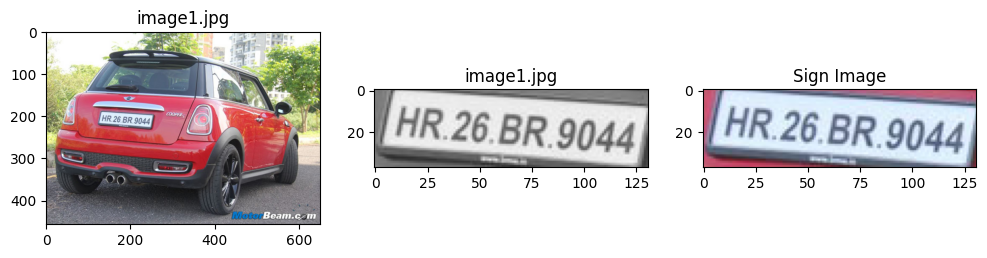

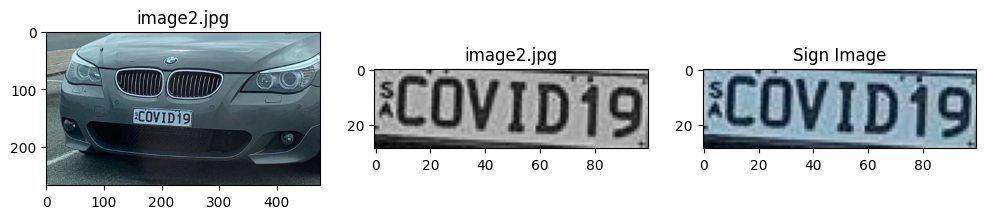

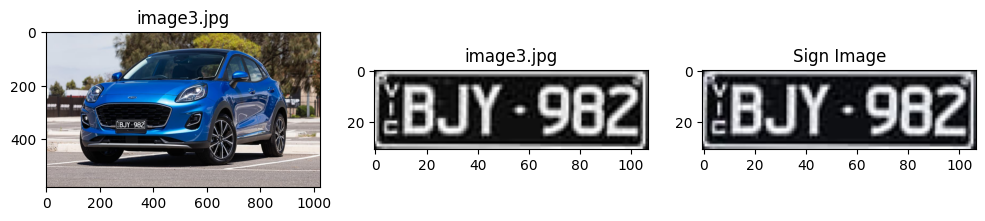

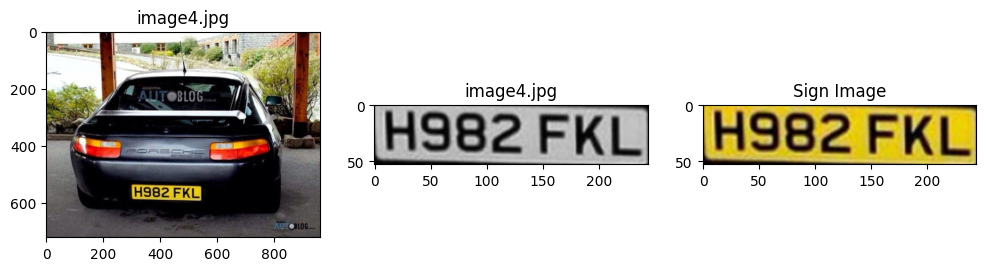

In [86]:
license_plates_dict = {'image_name': [], 'x': [], 'y': [], 'width': [], 'height': [] }

for file_name in file_names:
    img = cv2.imread(os.path.join(folder_path, file_name))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Make the image gray
    
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17) # Noise reduction
    edged = cv2.Canny(bfilter, 30, 200) # Edge detection
    
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # Find keypoints
    contours = imutils.grab_contours(keypoints) # Grab contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # Select the 10 largest contours 
    
    # Find the position of the license plate (rectangle search)
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
            
    # Extract the license plate from the original image
    mask = np.zeros(gray.shape, np.uint8) # create a blank mask
    new_image = cv2.drawContours(mask, [location], 0, 255, -1) # draw contours inside the mask image with location coordinates
    new_image = cv2.bitwise_and(img, img, mask=mask) # Applying masks on top of the original image
    (x, y) = np.where(mask==255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2 + 1, y1:y2 + 1]
    if location is None:
        print("\n LOCATION IS NONE!!!")
        break
        
    (x, y, w, h) = cv2.boundingRect(location)
    
    license_plates_dict['image_name'].append(file_name)
    license_plates_dict['x'].append(x)
    license_plates_dict['y'].append(y)
    license_plates_dict['width'].append(w)
    license_plates_dict['height'].append(h)
    
     # Create a sign image using (x, y, w, h) information
    sign_image = img[y:y+h, x:x+w]
    
    # Create a figure with two subplots: one for the car image and one for the license plate image
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    # Display the car image on the left subplot
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(file_name)

    # Display the license plate image in the middle subplot
    axes[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title(file_name)
    
     # Display the sign image on the right subplot
    axes[2].imshow(cv2.cvtColor(sign_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Sign Image')
    
    plt.show()  # Display the current image

In [90]:
license_plates_df = pd.DataFrame.from_dict(license_plates_dict)
license_plates_df.head()

,image_name,x,y,width,height
0,image1.jpg,122,191,131,37
1,image2.jpg,152,136,100,29
2,image3.jpg,263,333,107,31
3,image4.jpg,300,540,244,53
